In [2]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from skimage.io import imread
from torchvision import transforms
import matplotlib.pyplot as plt      # plot library.
from IPython.display import display 

from model.faster_rcnn.vgg16 import vgg16
from model.faster_rcnn.resnet import resnet

from frcnn_helper import *

%matplotlib inline

In [3]:
torch.cuda.empty_cache()

1.1.0


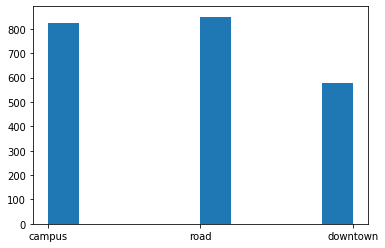

In [4]:
print(torch.__version__)

def scene_tag(file_name):
    set_tag = file_name.split('_')[0][-2:]
    if set_tag == "06" or set_tag == "09":
        return 'campus'
    if set_tag == "07" or set_tag == "10":
        return 'road'
    if set_tag == "08" or set_tag == "11":
        return 'downtown'

# Dealing with the filename first.
BASE_DIR = '/home/superorange5/data/kaist_test/kaist_test_visible'
file_names = [f for f in os.listdir(BASE_DIR) if '.png' in f]
scene_tags = [scene_tag(f) for f in file_names]

plt.hist(scene_tags);

In [5]:
%%time

model_campus  = torch.load('models/vgg16/KAIST/faster_rcnn_KAIST_3AVG/faster_rcnn_KAIST_campus_1_3_718.pth')
model_road = torch.load('models/vgg16/KAIST/faster_rcnn_KAIST_3AVG/faster_rcnn_KAIST_road_1_3_513.pth')
model_downtown = torch.load('models/vgg16/KAIST/faster_rcnn_KAIST_3AVG/faster_rcnn_KAIST_downtown_1_3_566.pth')

# model_ls = [model_campus, model_downtown, model_road]

CPU times: user 2.26 s, sys: 2.97 s, total: 5.23 s
Wall time: 7.46 s


In [ ]:
KAIST_classes = np.asarray(['__background__','person','people','cyclist'])

fasterRCNN = vgg16(KAIST_classes, pretrained=False, class_agnostic='class_agnostic')
fasterRCNN.create_architecture()
fasterRCNN.eval()
fasterRCNN.cuda()

vgg16(
  (RCNN_rpn): _RPN(
    (RPN_Conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (RPN_cls_score): Conv2d(512, 24, kernel_size=(1, 1), stride=(1, 1))
    (RPN_bbox_pred): Conv2d(512, 48, kernel_size=(1, 1), stride=(1, 1))
    (RPN_proposal): _ProposalLayer()
    (RPN_anchor_target): _AnchorTargetLayer()
  )
  (RCNN_proposal_target): _ProposalTargetLayer()
  (RCNN_roi_pool): ROIPool(output_size=(7, 7), spatial_scale=0.0625)
  (RCNN_roi_align): ROIAlign(output_size=(7, 7), spatial_scale=0.0625, sampling_ratio=0)
  (RCNN_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), 

In [ ]:
model = model_downtown

# load the model by cheating.
model['model']['RCNN_bbox_pred.weight'] = model['model']['RCNN_bbox_pred.weight'][:4]
model['model']['RCNN_bbox_pred.bias'] = model['model']['RCNN_bbox_pred.bias'][:4]

fasterRCNN.load_state_dict(model['model'])

In [ ]:
fasterRCNN

In [9]:
%%time 
def preproc_frcnn(img):
    """ follow the processing steps of fasterRCNN
    """
    img = np.asarray(img[:,:,::-1], dtype=np.float32)
    PIXEL_MEANS = np.array([[[102.9801, 115.9465, 122.7717]]])
    img -= PIXEL_MEANS
    
    return torch.tensor(img)

imgs_raw = [imread(os.path.join(BASE_DIR, fn)) for fn in file_names]

CPU times: user 25.7 s, sys: 1.42 s, total: 27.2 s
Wall time: 1min


In [8]:
%%time
imgs = [preproc_frcnn(img).unsqueeze(0).permute(0, 3, 1, 2) for img in imgs_raw]

CPU times: user 45.4 s, sys: 4.25 s, total: 49.6 s
Wall time: 12.8 s


In [9]:
%%time
# Extract feature map from the baselayer of frcnn

X = get_features(fasterRCNN, imgs, batch_sz=64)
torch.cuda.empty_cache()

print("Output shape: {:}".format(X.shape))

Output shape: (2252, 25088)
CPU times: user 42.6 s, sys: 11.6 s, total: 54.2 s
Wall time: 28.2 s


CPU times: user 10min 2s, sys: 8.7 s, total: 10min 11s
Wall time: 2min 41s


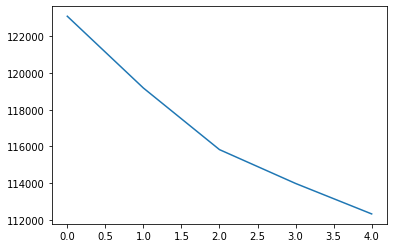

In [10]:
%%time
# calculate within-group disparesion for test.
gap_stats_k = [within_cluster_dispersion(X, n_cluster=k) for k in range(10, 20, 2)]

plt.plot(gap_stats_k)

In [11]:
# Load the prepared predictions from different FedAVG model.
x_campus = np.load('x_campus.npy')/255.0
x_downtown = np.load('x_downtown.npy')/255.0
x_road = np.load('x_road.npy')/255.0

CPU times: user 11min 10s, sys: 9.4 s, total: 11min 20s
Wall time: 2min 57s


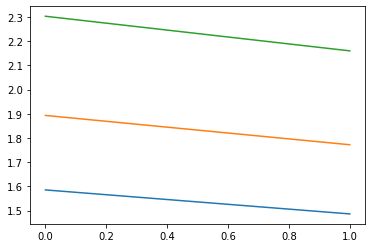

In [12]:
%%time

# Draw the within-cluster dispaersion for different model & [# of cluster].
gap_stats_ls = []
x_scences = [x_campus, x_downtown, x_road]
labels = ['campus', 'downtown', 'road']

K_CLUSTERS = [i for i in range(10, 20, 5)]

for x, lbl in zip(x_scences, labels):
    
    gap_stats_k = [within_cluster_dispersion(x, n_cluster=k) for k in K_CLUSTERS]
    gap_stats_ls.append(gap_stats_k)
    plt.plot(gap_stats_k, label=lbl)

In [13]:
# Apply softmax to derive proper weights for agregating models.
from scipy.special import softmax

pd.set_option('precision', 3)

gap_stats_np = np.asarray(gap_stats_ls)
df_res = pd.DataFrame(softmax(gap_stats_np, axis=0), columns=K_CLUSTERS, index=labels)

display(df_res)

,10,15
campus,0.227,0.233
downtown,0.308,0.310
road,0.465,0.457


In [14]:
def avgWeight(model_list):
    model_tmp=[None] * parties
    #optims_tmp=[None] * parties

    for idx, my_model in enumerate(model_list):
        
        model_tmp[idx] = my_model.state_dict()


    for key in model_tmp[0]:    
        #print(key)
        model_sum = 0

        for model_tmp_content in model_tmp:      
            
            model_sum += model_tmp_content[key]
            #print(model_tmp_content[key])
        for i in range(len(model_tmp)):
            #print("model_sum={}".format(model_sum))
            #print("len:{}".format(len(model_tmp)))
            model_avg = model_sum/len(model_tmp)
            #print("model_avg={}".format(model_avg))
            model_tmp[i][key] = model_sum/len(model_tmp)
    for i in range(len(model_list)):    
        model_list[i].load_state_dict(model_tmp[i])
        #optims_tmp[i] = Optims(workers, optim=optim.SGD(params=model_list[i].parameters(),lr=args.lr, momentum = args.momentum,weight_decay=args.weight_decay))
        #optims_tmp[i] = Optims(workers, optim=optim.Adam(params=model_list[i].parameters(),lr=args.lr))
    return model_list  #, optims_tmp

In [15]:
# model_ls = [model_campus, model_downtown, model_road]